# Section 4.1: Cardinality Distortion - Impact on Plan Quality

In [1]:
import sys
sys.path.append("../postbound/postbound")

In [2]:
import json
import collections

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import ticker

from postbound.db import db, postgres
from postbound.qal import base
from postbound.experiments import workloads
from postbound.optimizer import jointree

import analysis


In [3]:
results_base = "../datasets/01-cardinality-distortion"
workloads.workloads_base_dir = "../postbound/workloads"
plt.rcParams["figure.figsize"] = (15, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["ps.fonttype"] = 42
sns.set_style("whitegrid")
sns.set_context("talk")

## General definitions

In [4]:
job = workloads.job()
stats = workloads.stats()
(job, stats)

(Workload: JOB (113 queries), Workload: Stats (146 queries))

In [5]:
def explain_plan(explain_data: str) -> db.QueryExecutionPlan | None:
    json_data = json.loads(explain_data)
    if not json_data:
        return None
    pg_plan = postgres.PostgresExplainPlan(json_data)
    return pg_plan.as_query_execution_plan()


def parse_physical_qep(sample: pd.Series, *, workload: workloads.Workload[str]) -> jointree.PhysicalQueryPlan | None:
    if sample["query_plan"] is None:
        return None
    query = workload[sample["label"]]
    return jointree.PhysicalQueryPlan.load_from_query_plan(sample["query_plan"], query=query, operators_only=True)


def make_plan_idxs(sample: pd.Series) -> np.ndarray:
    sample = pd.Series(np.where(np.isnan(sample), sys.float_info.max, sample))
    unique_plans = sample.unique()
    plan_lookup = dict(zip(unique_plans, range(1, len(unique_plans) + 1)))

    lookup_fn = np.vectorize(lambda plan_hash: plan_lookup[plan_hash])
    return lookup_fn(sample)


def load_results(file: str, *, workload: workloads.Workload[str]) -> pd.DataFrame:
    data_file = f"{results_base}/{file}"
    distortion_df: pd.DataFrame = (pd.read_csv(data_file, converters={"query_plan": explain_plan})
                                   .query("distortion_factor <= 4")
                                   .pipe(analysis.label_sort))

    distortion_df["label"] = pd.Categorical(distortion_df["label"], categories=workload.labels(), ordered=True)
    distortion_df.sort_values(by=["server", "label", "distortion_factor"], inplace=True)  # sorting is important to determine the correct plan indexes
    distortion_df["plan_hash"] = distortion_df["query_plan"].apply(hash)
    distortion_df["plan_idx"] = distortion_df.groupby(["server", "label"], as_index=False, observed=True)["plan_hash"].transform(make_plan_idxs)
    distortion_df["timeout"] = np.isinf(distortion_df["runtime"])

    return distortion_df

In [6]:
job_df = load_results("card-distortion-job.csv", workload=job)
stats_df = load_results("card-distortion-stats.csv", workload=stats)

## Figure 3: Impact of cardinality misestimates on select JOB and Stats queries

In [7]:
def make_distortion_plot(df: pd.DataFrame, *, label: str, server: str, workload: str, suffix: str) -> None:
    sns.set_context("talk")

    current_sample = df.query("label == @label & server == @server").copy().sort_values(by="distortion_factor")

    fig, (ax_distortion, ax_plans) = plt.subplots(nrows=2, sharex=True, figsize=(7, 6))
    server_label = "HDD" if server == "hdd" else "SSD"

    g_distortion = sns.lineplot(current_sample, x="distortion_factor", y="runtime",
                                ax=ax_distortion)
    g_distortion.set(title=f"{workload} query {label} ({server_label} server)", ylabel="Runtime [s]")
    g_distortion.set_ylim(bottom=-10 if current_sample.runtime.min() < 1.0 and current_sample.runtime.max() > 5 else 0,
                          top=1.1 * current_sample.runtime.max())
    g_distortion.axvline(1.0, color="grey", linestyle="dashed")


    g_plans = sns.scatterplot(current_sample, x="distortion_factor", y="plan_idx", ax=ax_plans)
    g_plans.set(xlabel="Distortion factor", ylabel="Plan")
    g_plans.yaxis.set_major_locator(ticker.MaxNLocator(integer=True, nbins="auto", min_n_ticks=1))
    g_plans.axvline(1.0, color="grey", linestyle="dashed")


    fig.tight_layout()
    fig.savefig(f"plots/cardinality-distortion-{suffix}.pdf")

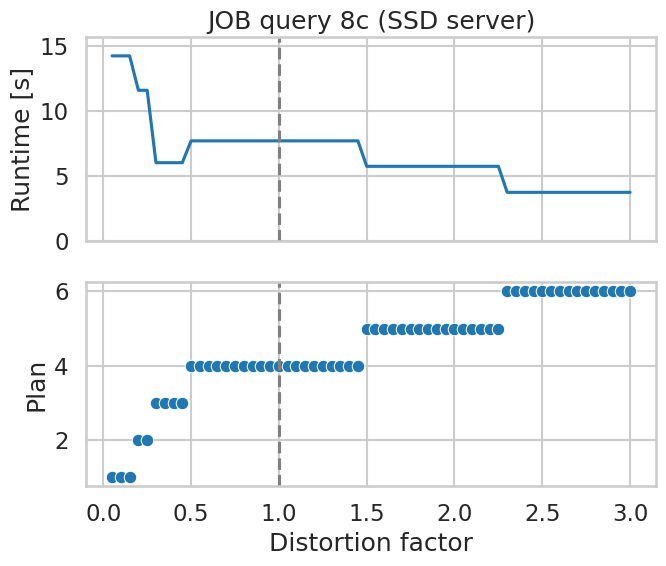

In [8]:
make_distortion_plot(job_df, label="8c", server="ssd", workload="JOB", suffix="evolution")

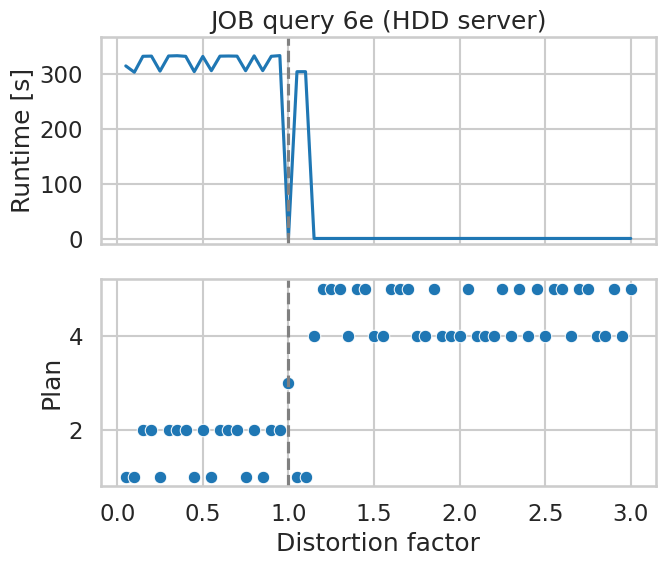

In [9]:
make_distortion_plot(job_df, label="6e", server="hdd", workload="JOB", suffix="jitter")

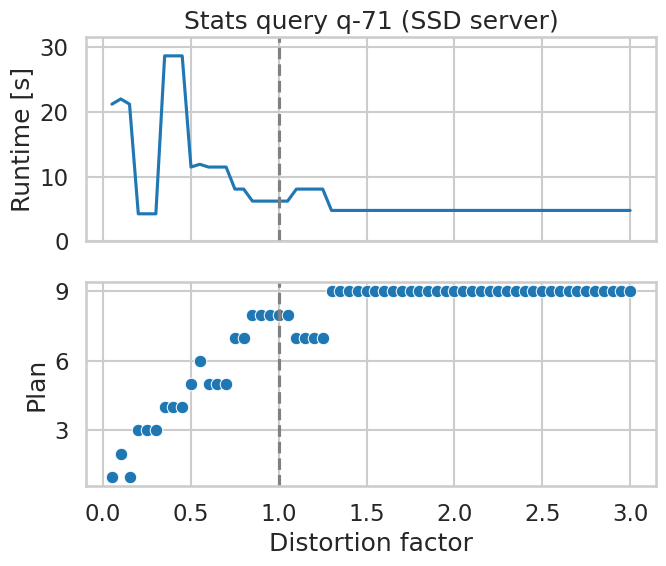

In [10]:
make_distortion_plot(stats_df, label="q-71", server="ssd", workload="Stats", suffix="stats-variable")

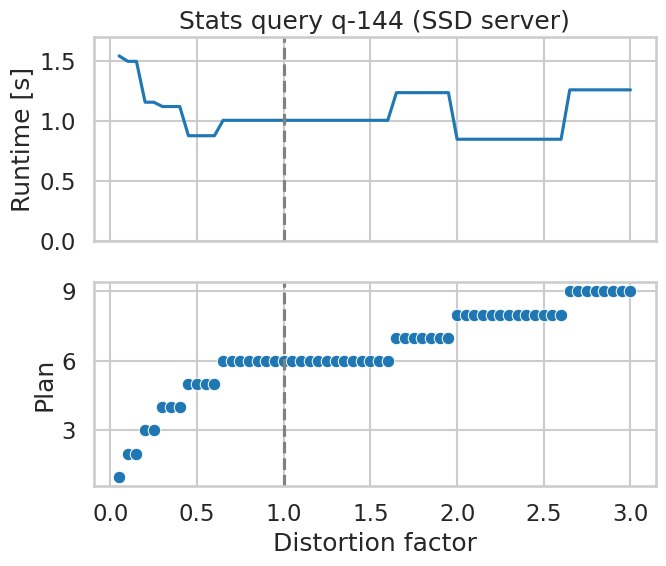

In [11]:
make_distortion_plot(stats_df, label="q-144", server="ssd", workload="Stats", suffix="stats-cost-corr")

## Figure 4: Slowdown of execution plans at different distortion factors

In [12]:
def make_slowdown_df(df: pd.DataFrame) -> pd.DataFrame:
    native_runtimes = df.query("distortion_factor == 1.0")[["label", "server", "runtime", "plan_hash"]]
    speedup_df = (df
                  .merge(native_runtimes, on=["label", "server"], suffixes=("", "_nat"))
                  .query("plan_hash != plan_hash_nat & ~timeout"))
    speedup_df["slowdown"] = speedup_df["runtime"] / speedup_df["runtime_nat"]
    return speedup_df


def make_slowdown_plot(df: pd.DataFrame, *, server: str, suffix: str) -> None:
    speedup_df = make_slowdown_df(df.query("server == @server"))

    plot_samples = speedup_df[speedup_df["distortion_factor"].isin([0.5, 0.9, 0.95, 1.05, 1.1, 1.5])]
    fig, ax = plt.subplots(figsize=(7,6))
    g = sns.boxplot(plot_samples, x="distortion_factor", y="slowdown", ax=ax)
    _ = g.set(xlabel="Distortion factor", ylabel="Slowdown to true cardinalities")
    g.set_yscale("log")

    g.get_figure().tight_layout()
    out_file = f"cardinality-distortion-slowdown-{suffix}.pdf" if suffix else "cardinality-distortion-slowdown.pdf"
    g.get_figure().savefig(f"plots/{out_file}")

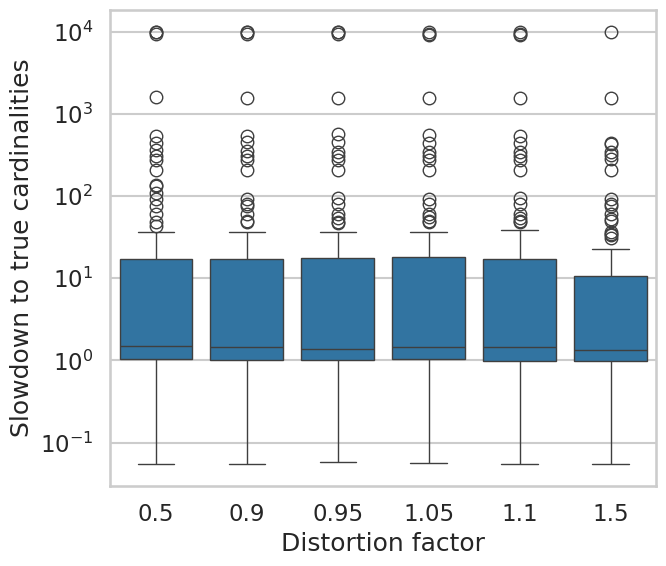

In [13]:
make_slowdown_plot(job_df, server="hdd", suffix="")

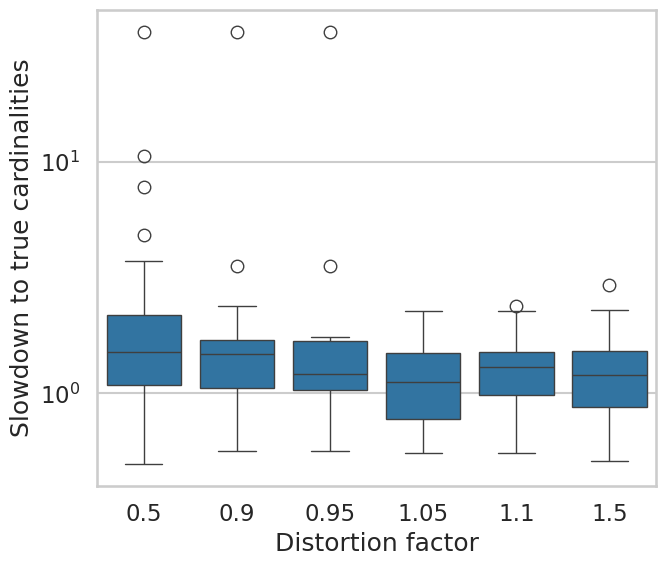

In [14]:
make_slowdown_plot(stats_df, server="ssd", suffix="stats")

## Numbers used throughout the text

### Characterization of plan changes (JOB)

**Number of stable/unstable/evolving queries:**

In [15]:
def count_jump_backs(plan_idxs) -> int:
    current_max = 0
    jumps = 0
    for i in plan_idxs:
        if i < current_max:
            jumps += 1
        if i > current_max:
            current_max = i
    return jumps

plans_per_query = job_df.groupby(["server", "label"], as_index=False, observed=True).agg(n_plans=pd.NamedAgg(column="plan_idx", aggfunc=lambda idxs: len(set(idxs))))
plan_selection_df: pd.DataFrame = (job_df
                                   .groupby(["server", "label"], as_index=False, observed=True)
                                   .agg(stable=pd.NamedAgg(column="plan_idx", aggfunc=lambda plans: len(set(plans)) == 1),
                                        jitter=pd.NamedAgg(column="plan_idx", aggfunc=lambda plans: count_jump_backs(plans) > 1))
                                   .pipe(analysis.label_sort))
plan_selection_df["evolution"] = ~(plan_selection_df["stable"] | plan_selection_df["jitter"])
plan_selection_df.groupby("server", as_index=False)[["stable", "jitter", "evolution"]].sum()

,server,stable,jitter,evolution
0,hdd,0,87,26
1,ssd,12,22,79


**Average number of plan changes per server:**

In [16]:
plans_per_query.groupby("server")["n_plans"].agg("mean")

server
hdd    5.460177
ssd    4.362832
Name: n_plans, dtype: float64

**Number of queries with a better plan at worse-than-perfect estimates:**

In [17]:
perfect_runtimes = job_df.query("distortion_factor == 1.0")[["label", "server", "runtime"]]
(job_df
 .merge(perfect_runtimes, on=["label", "server"], suffixes=("", "_perfect"))
 .query("runtime < runtime_perfect")
 .groupby(["label", "server"], as_index=False, observed=True)
 ["runtime"]
 .agg(lambda r: 1)  # mark the query as containing a better plan at worse estimate
 ["runtime"]
 .sum()
) / (2 * len(job))  # divide by 2 because we have two servers

np.float64(0.35398230088495575)

**Number of cardinality improvements that lead to a worse plan:**

In [18]:
def count_monotonicity_violations(df: pd.DataFrame, *, underest: bool) -> int:
    cmp_op = "<=" if underest else ">="
    prev_idx = 1 if underest else -1
    sample = df.query(f"distortion_factor {cmp_op} 1").copy()

    sample["prev_plan"] = sample.shift(prev_idx)["plan_hash"]
    sample["prev_rt"] = sample.shift(prev_idx)["runtime"]
    sample["prev_timeout"] = sample.shift(prev_idx)["timeout"].astype(float).fillna(False).astype(bool)

    violations = sample.query("prev_rt < runtime & prev_plan != plan_hash & (~timeout | ~prev_timeout)")
    return len(violations)


underest_violations: pd.DataFrame = (job_df
                                     .groupby(["server", "label"], as_index=False, observed=True)
                                     .apply(count_monotonicity_violations, include_groups=False, underest=True)
                                     .rename(columns={None: "violations"}))
overest_violations: pd.DataFrame = (job_df
                                    .groupby(["server", "label"], as_index=False, observed=True)
                                    .apply(count_monotonicity_violations, include_groups=False, underest=False)
                                    .rename(columns={None: "violations"}))
violations_df = underest_violations.merge(overest_violations, on=["server", "label"], suffixes=("_underest", "_overest"))
violations_df["violations_total"] = violations_df["violations_underest"] + violations_df["violations_overest"]
violations_df

,server,label,violations_underest,violations_overest,violations_total
0,hdd,1a,0,0,0
1,hdd,1b,1,1,2
2,hdd,1c,2,0,2
3,hdd,1d,2,0,2
4,hdd,2a,0,0,0
...,...,...,...,...,...
221,ssd,32a,0,0,0
222,ssd,32b,1,0,1
223,ssd,33a,1,3,4
224,ssd,33b,2,3,5


In [19]:
changes_df = job_df.copy()
changes_df["prev_plan"] = changes_df.shift(1)["plan_hash"]
changes_df["prev_server"] = changes_df.shift(1)["server"]
changes_df["prev_query"] = changes_df.shift(1)["label"]
total_changes = (changes_df
                 .query("plan_hash != prev_plan & server == prev_server & label == prev_query")
                 .groupby("server")
                 ["plan_hash"]
                 .count())
total_changes

server
hdd    692
ssd    464
Name: plan_hash, dtype: int64

In [20]:
total_violations = violations_df.groupby("server")["violations_total"].sum()
total_violations

server
hdd    235
ssd    180
Name: violations_total, dtype: int64

In [21]:
total_violations / total_changes

server
hdd    0.339595
ssd    0.387931
dtype: float64

### Bitmap-scan usage (JOB)

In [22]:
def extract_scan_op(plan: db.QueryExecutionPlan, table: base.TableReference) -> str:
    if not plan:
        return "<unknown>"
    scan_node = plan.find_first_node(lambda n: n.table == table)
    return scan_node.node_type if scan_node else "<unknown>"

def scan_op_df(sample: pd.DataFrame, label: str) -> pd.DataFrame:
    query = job[label]
    tab_names = [tab.alias for tab in query.tables()]

    for tab in query.tables():
        sample[tab.alias] = sample["query_plan"].apply(extract_scan_op, table=tab)

    return sample.melt(id_vars=["distortion_factor", "plan_idx"], value_vars=tab_names, var_name="base_tab", value_name="scan_op")

op_usage_hdd = collections.Counter()
op_usage_ssd = collections.Counter()
for label in job.labels():
    samples_hdd = job_df.query("label == @label & server == 'hdd'").copy()
    samples_ssd = job_df.query("label == @label & server == 'ssd'").copy()

    scan_ops_hdd = scan_op_df(samples_hdd, label)
    scan_ops_ssd = scan_op_df(samples_ssd, label)

    op_usage_hdd.update(scan_ops_hdd["scan_op"])
    op_usage_ssd.update(scan_ops_ssd["scan_op"])

op_usage_hdd, op_usage_ssd

(Counter({'Index Scan': 33999,
          'Seq Scan': 18240,
          'Bitmap Heap Scan': 3183,
          'Index Only Scan': 3178,
          '<unknown>': 20}),
 Counter({'Index Scan': 36210,
          'Seq Scan': 18926,
          'Index Only Scan': 3053,
          'Bitmap Heap Scan': 431}))

**Fraction of Bitmap scans on HDD:**

In [23]:
op_usage_hdd["Bitmap Heap Scan"] / sum(op_usage_hdd.values())

0.05429887410440123

**Fraction of Bitmap scans on SSD:**

In [24]:
op_usage_ssd["Bitmap Heap Scan"] / sum(op_usage_ssd.values())

0.007352439440464005

### Characterization of plan changes (Stats)

**Number of stable/unstable/evolving queries:**

In [25]:
plans_per_query = stats_df.groupby(["server", "label"], as_index=False, observed=True).agg(n_plans=pd.NamedAgg(column="plan_idx", aggfunc=lambda idxs: len(set(idxs))))
plan_selection_df: pd.DataFrame = (stats_df
                                   .groupby(["server", "label"], as_index=False, observed=True)
                                   .agg(stable=pd.NamedAgg(column="plan_idx", aggfunc=lambda plans: len(set(plans)) == 1),
                                        jitter=pd.NamedAgg(column="plan_idx", aggfunc=lambda plans: count_jump_backs(plans) > 1))
                                   .pipe(analysis.label_sort))
plan_selection_df["evolution"] = ~(plan_selection_df["stable"] | plan_selection_df["jitter"])
plan_selection_df.groupby("server", as_index=False)[["stable", "jitter", "evolution"]].sum()

,server,stable,jitter,evolution
0,ssd,7,23,116


**Average number of plan changes:**

In [26]:
plans_per_query.groupby("server")["n_plans"].agg("mean")

server
ssd    4.842466
Name: n_plans, dtype: float64